## Import Packages 

In [5]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

## Import GTA Reviews from Steam 

In [6]:
df = pd.read_csv('gta_data.csv')
df.head()

,Unnamed: 0,app_name,language,review,recommended
0,12750210,Grand Theft Auto V,english,It's fun.\nWish the loading times for Online w...,True
1,12750213,Grand Theft Auto V,english,hn,True
2,12750214,Grand Theft Auto V,english,---{Graphics}---\n☐ You forget what reality is...,True
3,12750216,Grand Theft Auto V,english,a,True
4,12750223,Grand Theft Auto V,english,It is one of the best games I’ve played.. Too ...,True


## Data Cleaning and Text Preprocessing

**TEXT PRE-PROCESSING**

For our business case, we want to look only at reviews concerning Grand Theft Auto 5, that are in English, and that are negative. We will filter out all other reviews that are in our dataset that do not meet these requirements. 

In [7]:
#drop positive reviews
df = df.drop(df[df['recommended'] == True].index)
df['cleaned_reviews'] = df['review'].astype(str)
df['cleaned_reviews'].astype(str)

# Convert to lowercase 
df['cleaned_reviews'] = df['cleaned_reviews'].map(lambda x: x.lower())

# replace common entities/concept 
from textacy.preprocessing.replace import urls, hashtags, numbers, emails, emojis, currency_symbols
df["cleaned_reviews"] = df['cleaned_reviews'].\
  apply(urls).\
  apply(hashtags).\
  apply(numbers).\
  apply(currency_symbols).\
  apply(emojis).\
  apply(emails).\
  apply(numbers)
# remove punctuation
from textacy.preprocessing.remove import punctuation
df["cleaned_reviews"] = df['cleaned_reviews'].apply(punctuation)

We downloaded stopwords fromthe NLTK library. Since a lot of the reviews have foul language that doesn't add to our analysis of topic modeling, we will be adding some custom stopwords. 

In [8]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# Adding custom stopwords to optimize our model 
new_stopwords = ['number', 'shit', 'fucking', 'card', 'way', 'emoji','fuck', 'bad','ass','gay','online','play','two','much', 'suck', 'game']
stop_words.extend(new_stopwords)
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [9]:
df.sample(10)

,Unnamed: 0,app_name,language,review,recommended,cleaned_reviews
229184,13534382,Grand Theft Auto V,english,Game was pretty good long ago before they deci...,False,game was pretty good long ago before they deci...
239028,13547362,Grand Theft Auto V,english,Fuck you Take Two Interactive. I can't play as...,False,fuck you take two interactive i can t play as...
277287,13657568,Grand Theft Auto V,english,"the servres of the game are very poor, when u ...",False,the servres of the game are very poor when u ...
189388,13414475,Grand Theft Auto V,english,ich habe einen ban for nothing fucking rokstar...,False,ich habe einen ban for nothing fucking rokstar...
230374,13536157,Grand Theft Auto V,english,"Fuck you Take 2, shit that even rhymed, well y...",False,fuck you take NUMBER shit that even rhymed ...
244614,13553443,Grand Theft Auto V,english,Just here to grab a slice of that delicious ou...,False,just here to grab a slice of that delicious ou...
218669,13518736,Grand Theft Auto V,english,Fix it,False,fix it
62121,12952998,Grand Theft Auto V,english,shits fucking broken cant change any settings,False,shits fucking broken cant change any settings
285132,13682839,Grand Theft Auto V,english,Greed Killed this game. Cheaters/Moders are on...,False,greed killed this game cheaters moders are on...
241854,13550483,Grand Theft Auto V,english,2K hates modders. That's ok. PC gamers hate ...,False,2k hates modders that s ok pc gamers hate ...


We tokenized each sentence into a list of words while removing punctuation and unnecesary characters. We used Gensim's `simple_preprocees` to do this. 

In [10]:
data = df.cleaned_reviews.values.tolist()

# Tokenize each sentence into a list of words 
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))
print(data_words[:1])

[['hackers', 'in', 'every', 'lobby']]


We used bigram and trigram models using Gensim's `Phrases` method to find two word pairs or three word groups that appear frequently in our corpus. This will help us isolate the key topics from our messey and sparse review data. 

In [11]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['hackers', 'in', 'every', 'lobby']


Here, we remoce stopwords we defined previously, make bigrams and trigrams using the model we defined above, and perform lemmatization using `spacy`. 

In [12]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [13]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load("en_core_web_md", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

/Users/jewonju/opt/anaconda3/lib/python3.9/site-packages/spacy/language.py:1895: UserWarning: [W123] Argument disable with value ['parser', 'ner'] is used instead of ['senter'] as specified in the config. Be aware that this might affect other components in your pipeline.
  warnings.warn(


[['hacker', 'lobby']]


## LDA Model

In [14]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1)]]


In [15]:
# Build LDA model with 20 topics to begin with 
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [16]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/Users/jewonju/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/jewonju/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jewonju/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jewonju/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jewonju/opt/anaconda3/lib/

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
13    -0.291646 -0.202501       1        1  31.405394
9     -0.290442 -0.195585       2        1  27.136720
4     -0.161206  0.337740       3        1   8.409903
18    -0.083167  0.132891       4        1   4.297670
10    -0.036703  0.064136       5        1   3.607744
17    -0.044615  0.073357       6        1   3.400740
5     -0.005489  0.029360       7        1   2.415658
1     -0.016367  0.041069       8        1   2.334614
7      0.004268  0.020213       9        1   2.090695
2      0.030759 -0.001686      10        1   2.061909
3     -0.016796  0.041139      11        1   2.025206
6      0.095396 -0.041549      12        1   1.846882
19     0.055317 -0.019159      13        1   1.767932
15     0.087734 -0.037595      14        1   1.623731
11     0.070829 -0.028376      15        1   1.237500
8      0.042355 -0.009833      16        1   1.137795
14     0.053798 -0.017604      17        1   1.076305
0      0.152906 -0.064065      18        1   1.075078
16     0.134978 -0.058195      19        1   1.039681
12     0.218092 -0.063754      20        1   0.008843, topic_info=         Term          Freq         Total Category  logprob  loglift
441       mod  18038.000000  18038.000000  Default  30.0000  30.0000
34        ban  20958.000000  20958.000000  Default  29.0000  29.0000
26        get  48620.000000  48620.000000  Default  28.0000  28.0000
62   rockstar  42144.000000  42144.000000  Default  27.0000  27.0000
219     modde  11335.000000  11335.000000  Default  26.0000  26.0000
..        ...           ...           ...      ...      ...      ...
25      exist      0.004576    721.381330  Topic20 -10.4104  -2.6348
26        get      0.004576  48620.113103  Topic20 -10.4104  -6.8454
27    glitchy      0.004576    225.539512  Topic20 -10.4104  -1.4721
28    mislead      0.004576      1.110733  Topic20 -10.4104   3.8414
29     ridden      0.004576     20.772229  Topic20 -10.4104   0.9128

[874 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
316       1  0.999848        able
139      13  0.998482    absolute
65       18  0.999375  absolutely
58        4  0.999751     account
101       1  0.999718    actually
...     ...       ...         ...
167       9  0.998856         win
314       3  0.999893        work
238       1  0.999792       worth
684       4  0.999369       wrong
407       4  0.999915        year

[398 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 10, 5, 19, 11, 18, 6, 2, 8, 3, 4, 7, 20, 16, 12, 9, 15, 1, 17, 13])

The bubbles on the left-hand slide plot represents each of the topics in the model. The size of the bubble represents how prevalent the topic is. If the bubbles are non-overlapping and scattered throughout the chart, then the model is good. In our case, there are many overlapping bubbles, which indicates we need to do further optimization to get better results. 

## Model Optimization

Topic coherence value measures how good a given topic model is. Therefore, we will use coherence valeus to determine the optimal number of topics to look at for our topic modeling.  

In [17]:
# Define a function for computing the coherence value for a given number of topic 
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel( corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [18]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

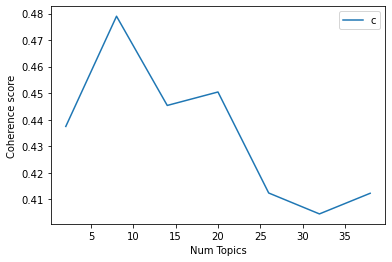

In [19]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [20]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4375
Num Topics = 8  has Coherence Value of 0.479
Num Topics = 14  has Coherence Value of 0.4454
Num Topics = 20  has Coherence Value of 0.4505
Num Topics = 26  has Coherence Value of 0.4124
Num Topics = 32  has Coherence Value of 0.4045
Num Topics = 38  has Coherence Value of 0.4123


Looking at the result, we decided that 8 topics was ideal for our topic modeling because it has the highest Coherence value.

In [21]:
# Select the model and print the topics
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.081*"player" + 0.072*"single" + 0.041*"money" + 0.022*"buy" + '
  '0.022*"multiplayer" + 0.020*"mod" + 0.020*"take" + 0.019*"fun" + '
  '0.018*"want" + 0.017*"pay"'),
 (1,
  '0.137*"loading" + 0.080*"screen" + 0.064*"load" + 0.049*"wait" + '
  '0.047*"take" + 0.047*"time" + 0.026*"crash" + 0.024*"minute" + 0.018*"suck" '
  '+ 0.018*"long"'),
 (2,
  '0.022*"fix" + 0.020*"crash" + 0.019*"hacker" + 0.018*"server" + '
  '0.018*"issue" + 0.016*"many" + 0.016*"get" + 0.015*"problem" + '
  '0.014*"session" + 0.013*"bug"'),
 (3,
  '0.049*"rockstar" + 0.029*"buy" + 0.023*"work" + 0.018*"even" + '
  '0.018*"steam" + 0.014*"support" + 0.014*"try" + 0.012*"game" + '
  '0.012*"launch" + 0.012*"account"'),
 (4,
  '0.056*"hacker" + 0.045*"good" + 0.039*"mod" + 0.029*"singleplayer" + '
  '0.029*"ruin" + 0.022*"multiplayer" + 0.018*"great" + 0.017*"rip" + '
  '0.017*"rockstar" + 0.013*"kill"'),
 (5,
  '0.062*"pc" + 0.026*"community" + 0.019*"console" + 0.019*"version" + '
  '0.018*"hate" + 0.

In [22]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [23]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/Users/jewonju/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/jewonju/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/jewonju/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/jewonju/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/jewonju/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:3

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.349535 -0.287166       1        1  38.706522
2     -0.088195  0.212205       2        1  15.568495
4     -0.168566  0.254199       3        1  14.744661
6      0.028772  0.112674       4        1  10.462332
0      0.136741 -0.079476       5        1   6.768921
1      0.146161 -0.105537       6        1   6.317612
7      0.148575 -0.057850       7        1   4.389289
3      0.146047 -0.049050       8        1   3.042169, topic_info=           Term          Freq         Total Category  logprob  loglift
62     rockstar  27606.000000  27606.000000  Default  30.0000  30.0000
34          ban  14264.000000  14264.000000  Default  29.0000  29.0000
26          get  33820.000000  33820.000000  Default  28.0000  28.0000
285      player  16809.000000  16809.000000  Default  27.0000  27.0000
56         time  14777.000000  14777.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
909      refuse    460.406223    461.169952   Topic8  -4.7321   3.4909
252     totally    458.917218    459.681133   Topic8  -4.7353   3.4909
1280  beautiful    454.945079    455.708971   Topic8  -4.7440   3.4909
540    properly    422.961123    423.725085   Topic8  -4.8169   3.4908
1781       meet    407.149258    407.913036   Topic8  -4.8550   3.4907

[284 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
139       6  0.998180  absolute
58        6  0.999948   account
101       2  0.858090  actually
101       3  0.141721  actually
141       2  0.999736       add
...     ...       ...       ...
2774      4  0.998864    window
314       3  0.999917      work
237       4  0.999504     world
407       2  0.999902      year
32        2  0.999551       yet

[270 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 5, 7, 1, 2, 8, 4])